## Introduction
As the first part of this project to find the optimal location for a Colombian restaurant in Madrid. It is first needed to analyze the city's most typical venues by neighborhood to have an idea of which are the actual leisure places where people go spending their time. To start this analysis, Neighborhood Clusters will be created and their venues analysed in similarity terms.

Once the most frequent venues per neighborhood are extracted; the second part of this project, a segmentation by nationality of the people living in each neighborhood is going to be carried out to determine in which one would be more advisable to open a Colombian food restaurant based on the results and the analised venues.

For this project, the data that will be used to analyse the venues are obtained from the Foursquare API and the Madrid's City Hall. 

### Import necessary Libraries

In [1]:
import numpy as np # library to handle data in a vectorized fashion

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # import k-means from clustering stage

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Read and explore the data

In [2]:
df = pd.read_csv('Madrid Districts.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
print(len(df))
df.head()

39


,Country of Origin,Total Ciudad de Madrid,Centro,Arganzuela,Retiro,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas
0,Rumanía,45036.0,815.0,754.0,480.0,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0
1,China,37276.0,1508.0,1356.0,564.0,755.0,652.0,1988.0,816.0,1733.0,960.0,2554.0,4398.0,9207.0,3602.0,564.0,1960.0,1104.0,1236.0,685.0,472.0,972.0,190.0
2,Ecuador,23953.0,647.0,741.0,265.0,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0
3,Venezuela,23359.0,1563.0,913.0,638.0,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0
4,Colombia,22618.0,998.0,717.0,483.0,803.0,551.0,822.0,659.0,999.0,454.0,1786.0,3395.0,1752.0,1733.0,482.0,1792.0,910.0,1618.0,740.0,384.0,1282.0,258.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 23 columns):
Country of Origin         37 non-null object
Total Ciudad de Madrid    34 non-null float64
Centro                    34 non-null float64
Arganzuela                34 non-null float64
Retiro                    34 non-null float64
Salamanca                 34 non-null float64
Chamartin                 34 non-null float64
Tetuán                    34 non-null float64
Chamberí                  34 non-null float64
Fuencarral-El Pardo       34 non-null float64
Moncloa-Aravaca           34 non-null float64
Latina                    34 non-null float64
Carabanchel               34 non-null float64
Usera                     34 non-null float64
Puente de Vallecas        34 non-null float64
Moratalaz                 34 non-null float64
Ciudad Lineal             34 non-null float64
Hortaleza                 34 non-null float64
Villaverde                34 non-null float64
Villa de Vallecas       

In [4]:
df.isnull().sum()

Country of Origin         2
Total Ciudad de Madrid    5
Centro                    5
Arganzuela                5
Retiro                    5
Salamanca                 5
Chamartin                 5
Tetuán                    5
Chamberí                  5
Fuencarral-El Pardo       5
Moncloa-Aravaca           5
Latina                    5
Carabanchel               5
Usera                     5
Puente de Vallecas        5
Moratalaz                 5
Ciudad Lineal             5
Hortaleza                 5
Villaverde                5
Villa de Vallecas         5
Vicálvaro                 5
San Blas-Canillejas       5
Barajas                   5
dtype: int64

In [5]:
df.fillna(method = 'ffill', inplace = True)
df.fillna(method = 'bfill', inplace = True)

### Create a new dataframe with the coordinates of Madrid's distritcts¶

In [6]:
coordinates_df = pd.DataFrame( data = {

'District' : ['Centro', 'Arganzuela', 'Retiro', 'Salamanca', 'Chamartin',
                'Tetuán', 'Chamberí', 'Fuencarral-El Pardo', 'Moncloa-Aravaca', 'Latina', 'Carabanchel',
                'Usera', 'Puente de Vallecas', 'Moratalaz', 'Ciudad Lineal', 'Hortaleza', 'Villaverde',
                'Villa de Vallecas', 'Vicálvaro', 'San Blas-Canillejas', 'Barajas'],
'Latitude' : ['40.415347', '40.402733', '40.408072', '40.43', '40.453333', '40.460556', '40.432792', '40.478611', '40.435151',
                 '40.402461', '40.383669', '40.381336', '40.398204', '40.409869', '40.45', '40.469457', '40.345925', '40.3796', 
                 '40.4042', '40.426001', '40.470196'],
'Longitude' : ['-3.707371', '-3.695403', '-3.676729', '-3.677778', '-3.6775', '-3.7', '-3.697186', '-3.709722', '-3.718765', 
                  '-3.741294', '-3.727989', '-3.706856', '-3.669059', '-3.644436', '-3.65', '-3.640482', '-3.709356', '-3.62135', 
                  '-3.60806', '-3.612764', '-3.58489']})

In [7]:
coordinates_df.head(21)

,District,Latitude,Longitude
0,Centro,40.415347,-3.707371
1,Arganzuela,40.402733,-3.695403
2,Retiro,40.408072,-3.676729
3,Salamanca,40.43,-3.677778
4,Chamartin,40.453333,-3.6775
5,Tetuán,40.460556,-3.7
6,Chamberí,40.432792,-3.697186
7,Fuencarral-El Pardo,40.478611,-3.709722
8,Moncloa-Aravaca,40.435151,-3.718765
9,Latina,40.402461,-3.741294


In [8]:
coordinates_df.info

<bound method DataFrame.info of                District   Latitude  Longitude
0                Centro  40.415347  -3.707371
1            Arganzuela  40.402733  -3.695403
2                Retiro  40.408072  -3.676729
3             Salamanca      40.43  -3.677778
4             Chamartin  40.453333    -3.6775
5                Tetuán  40.460556       -3.7
6              Chamberí  40.432792  -3.697186
7   Fuencarral-El Pardo  40.478611  -3.709722
8       Moncloa-Aravaca  40.435151  -3.718765
9                Latina  40.402461  -3.741294
10          Carabanchel  40.383669  -3.727989
11                Usera  40.381336  -3.706856
12   Puente de Vallecas  40.398204  -3.669059
13            Moratalaz  40.409869  -3.644436
14        Ciudad Lineal      40.45      -3.65
15            Hortaleza  40.469457  -3.640482
16           Villaverde  40.345925  -3.709356
17    Villa de Vallecas    40.3796   -3.62135
18            Vicálvaro    40.4042   -3.60806
19  San Blas-Canillejas  40.426001  -3.612764
20

In [9]:
coordinates_df['Latitude'] = coordinates_df['Latitude'].astype('float', errors = 'ignore')
coordinates_df['Longitude'] = coordinates_df['Longitude'].astype('float', errors = 'ignore')
coordinates_df.dtypes

District      object
Latitude     float64
Longitude    float64
dtype: object

### Map of Madrid with its corresponding districts

In [10]:
latitude = 40.4167047
longitude = -3.7035825

map_mad = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mad)  
    
map_mad

### Explore the Neighborhoods with Foursquare data
#### Define Foursquare credentials and version

In [11]:
CLIENT_ID = 'FRI4BGBGLDEYD5LXOQC4YHL2JSBGEVH3YZOOWYAYQAER3JT1' # Foursquare ID
CLIENT_SECRET = 'NRO5GQMSGXXIETJQCTAU1QILZNMCTZZJYREMM21E205P523Z' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: FRI4BGBGLDEYD5LXOQC4YHL2JSBGEVH3YZOOWYAYQAER3JT1
CLIENT_SECRET:NRO5GQMSGXXIETJQCTAU1QILZNMCTZZJYREMM21E205P523Z


### Get the top 100 venues in Rouge in a radius of 500 metters

## Get the first Neighborhood's name

In [12]:
coordinates_df.loc[0, 'District']

'Centro'

Now let's get the latitude and longitude of this district

In [13]:
district_latitude = coordinates_df.loc[0, 'Latitude'] # District latitude value
district_longitude = coordinates_df.loc[0, 'Longitude'] # District longitude value

district_name = coordinates_df.loc[0, 'District'] # District name

print('Latitude and longitude values of {} are {}, {}.'.format(district_name, 
                                                               district_latitude, 
                                                               district_longitude))

Latitude and longitude values of Centro are 40.415347, -3.707371.


In [14]:
LIMIT= 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    district_latitude, 
    district_longitude, 
    radius, 
    LIMIT)

In [15]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f14f13da536c57dc688c261'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Plaza Mayor',
  'headerFullLocation': 'Plaza Mayor, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 97,
  'suggestedBounds': {'ne': {'lat': 40.4198470045, 'lng': -3.701471589889844},
   'sw': {'lat': 40.410846995499995, 'lng': -3.7132704101101566}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda37f964a520193c21e3',
       'name': 'Plaza Mayor',
       'location': {'address': 'Pl. Mayor',
        'lat': 40.415526598647354,
        'lng': -3.7075061894121037,
        'distance': 23,
        'postalCode': '28012',
        'cc': 'ES',
      

In [16]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Plaza Mayor,Plaza,40.415527,-3.707506
1,The Hat Madrid,Hotel,40.414343,-3.707120
2,La Taberna de Mister Pinkleton,Other Nightlife,40.414536,-3.708108
3,Mercado de San Miguel,Market,40.415443,-3.708943
4,Plaza Santa Cruz,Plaza,40.415063,-3.705661


In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

97 venues were returned by Foursquare.


### Let's create a function that repeats all the above process for all the districts in Madrid to explore them more deeply

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
Madrid_venues = getNearbyVenues(names= coordinates_df['District'],
                                   latitudes= coordinates_df['Latitude'],
                                   longitudes= coordinates_df['Longitude']
                                  )

Centro
Arganzuela
Retiro
Salamanca
Chamartin
Tetuán
Chamberí
Fuencarral-El Pardo
Moncloa-Aravaca
Latina
Carabanchel
Usera
Puente de Vallecas
Moratalaz
Ciudad Lineal
Hortaleza
Villaverde
Villa de Vallecas
Vicálvaro
San Blas-Canillejas
Barajas


#### Check the size of our new dataframe

In [21]:
print(Madrid_venues.shape)
Madrid_venues.head()

(733, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.415347,-3.707371,Plaza Mayor,40.415527,-3.707506,Plaza
1,Centro,40.415347,-3.707371,The Hat Madrid,40.414343,-3.707120,Hotel
2,Centro,40.415347,-3.707371,La Taberna de Mister Pinkleton,40.414536,-3.708108,Other Nightlife
3,Centro,40.415347,-3.707371,Mercado de San Miguel,40.415443,-3.708943,Market
4,Centro,40.415347,-3.707371,Plaza Santa Cruz,40.415063,-3.705661,Plaza


#### Let's find out how many venues there are by district

In [22]:
Madrid_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Arganzuela,88,88,88,88,88,88
Barajas,31,31,31,31,31,31
Carabanchel,10,10,10,10,10,10
Centro,97,97,97,97,97,97
Chamartin,51,51,51,51,51,51
Chamberí,100,100,100,100,100,100
Ciudad Lineal,28,28,28,28,28,28
Fuencarral-El Pardo,37,37,37,37,37,37
Hortaleza,19,19,19,19,19,19


#### Let's now analyze each district in detail

In [23]:
# One hot encoding
madrid_onehot = pd.get_dummies(Madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# Add district column back to dataframe
madrid_onehot['District'] = Madrid_venues['District'] 

# Move district column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]
madrid_onehot.head()

,District,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Cosmetics Shop,Cuban Restaurant,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Resort,Restaurant,Road,Rock Club,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trade School,Train Station,Udon Restaurant,Video Game Store,Wine Bar,Women's Store
0,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
madrid_onehot.shape

(733, 159)

#### Group each district and get the mean ocurrence of each venue category

In [25]:
madrid_grouped = madrid_onehot.groupby('District').mean().reset_index()
madrid_grouped

,District,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Cosmetics Shop,Cuban Restaurant,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Opera House,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Polish Restaurant,Pub,Ramen Restaurant,Resort,Restaurant,Road,Rock Club,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trade School,Train Station,Udon Restaurant,Video Game Store,Wine Bar,Women's Store
0,Arganzuela,0.000000,0.022727,0.000000,0.000000,0.00,0.00000,0.011364,0.000000,0.000000,0.056818,0.000000,0.011364,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.022727,0.011364,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.011364,0.000000,0.000000,0.011364,0.000000,0.011364,0.000000,0.011364,0.011364,0.000000,0.011364,0.011364,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.022727,0.011364,0.000000,0.000000,0.011364,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.056818,0.011364,0.034091,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.022727,0.000000,0.000000,0.000000,0.011364,0.011364,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.011364,0.000000,0.011364,0.011364,0.000000,0.000000,0.000000,0.011364,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.011364,0.022727,0.000000,0.011364,0.000000,0.00000,0.102273,0.000000,0.000000,0.000000,0.011364,0.022727,0.000000,0.011364,0.000000,0.000000,0.011364,0.000000,0.000000,0.00,0.102273,0.000000,0.000000,0.000000,0.000000,0.045455,0.011364,0.00,0.011364,0.000000,0.011364,0.011364,0.000000,0.011364,0.011364,0.000000,0.000000,0.000000,0.000000
1,Barajas,0.000000,0.000000,0.032258,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.0000,0.032258,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.00000

In [26]:
madrid_grouped.shape

(21, 159)

#### 5 top venues by district

In [27]:
num_top_venues = 5

for hood in madrid_grouped['District']:
    print("----"+hood+"----")
    temp = madrid_grouped[madrid_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arganzuela----
                venue  freq
0  Spanish Restaurant  0.10
1          Restaurant  0.10
2       Grocery Store  0.06
3              Bakery  0.06
4    Tapas Restaurant  0.05


----Barajas----
                venue  freq
0               Hotel  0.19
1  Spanish Restaurant  0.10
2          Restaurant  0.10
3         Coffee Shop  0.06
4    Tapas Restaurant  0.06


----Carabanchel----
                  venue  freq
0                 Plaza   0.1
1                Bakery   0.1
2  Fast Food Restaurant   0.1
3             Nightclub   0.1
4          Soccer Field   0.1


----Centro----
                venue  freq
0               Plaza  0.11
1    Tapas Restaurant  0.11
2  Spanish Restaurant  0.09
3              Hostel  0.04
4         Coffee Shop  0.03


----Chamartin----
                venue  freq
0          Restaurant  0.14
1  Spanish Restaurant  0.14
2    Tapas Restaurant  0.06
3       Grocery Store  0.06
4              Bakery  0.06


----Chamberí----
                 venue  freq
0   

#### Let's sort the venues out in descending order

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Let's put this into a new pandas dataframe and show the Top Ten venues per district

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = madrid_grouped['District']

for ind in np.arange(madrid_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Restaurant,Spanish Restaurant,Bakery,Grocery Store,Tapas Restaurant,Gym / Fitness Center,Falafel Restaurant,Burger Joint,Hotel,Plaza
1,Barajas,Hotel,Restaurant,Spanish Restaurant,Coffee Shop,Tapas Restaurant,Supermarket,Mexican Restaurant,Brewery,Breakfast Spot,Plaza
2,Carabanchel,Metro Station,Soccer Field,Burger Joint,Mobile Phone Shop,Pizza Place,Plaza,Nightclub,Bakery,Fast Food Restaurant,Tapas Restaurant
3,Centro,Plaza,Tapas Restaurant,Spanish Restaurant,Hostel,Coffee Shop,Bistro,Ice Cream Shop,Café,Cocktail Bar,Mexican Restaurant
4,Chamartin,Spanish Restaurant,Restaurant,Grocery Store,Tapas Restaurant,Bakery,Coffee Shop,Japanese Restaurant,Gastropub,Park,Pizza Place
5,Chamberí,Spanish Restaurant,Restaurant,Bar,Café,Brewery,Japanese Restaurant,Tapas Restaurant,Mexican Restaurant,Plaza,Italian Restaurant
6,Ciudad Lineal,Spanish Restaurant,Gastropub,Supermarket,Restaurant,Burger Joint,Argentinian Restaurant,Pizza Place,Cocktail Bar,Café,Gym / Fitness Center
7,Fuencarral-El Pardo,Clothing Store,Fast Food Restaurant,Burger Joint,Italian Restaurant,Tapas Restaurant,Sporting Goods Shop,Pizza Place,Restaurant,Chocolate Shop,Kebab Restaurant
8,Hortaleza,Breakfast Spot,Supermarket,Pizza Place,Plaza,Bar,Food,Restaurant,Chinese Restaurant,Spanish Restaurant,Pub
9,Latina,Metro Station,Pizza Place,Grocery Store,Falafel Restaurant,Fast Food Restaurant,Shopping Mall,Bakery,Park,Train Station,Greek Restaurant


## Get districts' clusters
#### First, let's determine the optimal value of K for our dataset by using the Elbow method

In [30]:
madrid_grouped_clustering = madrid_grouped.drop('District', 1)

Sum_of_squared_distances = []
K = range(1, 22)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(madrid_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

## Plot and visualize optimal K¶

In [31]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k

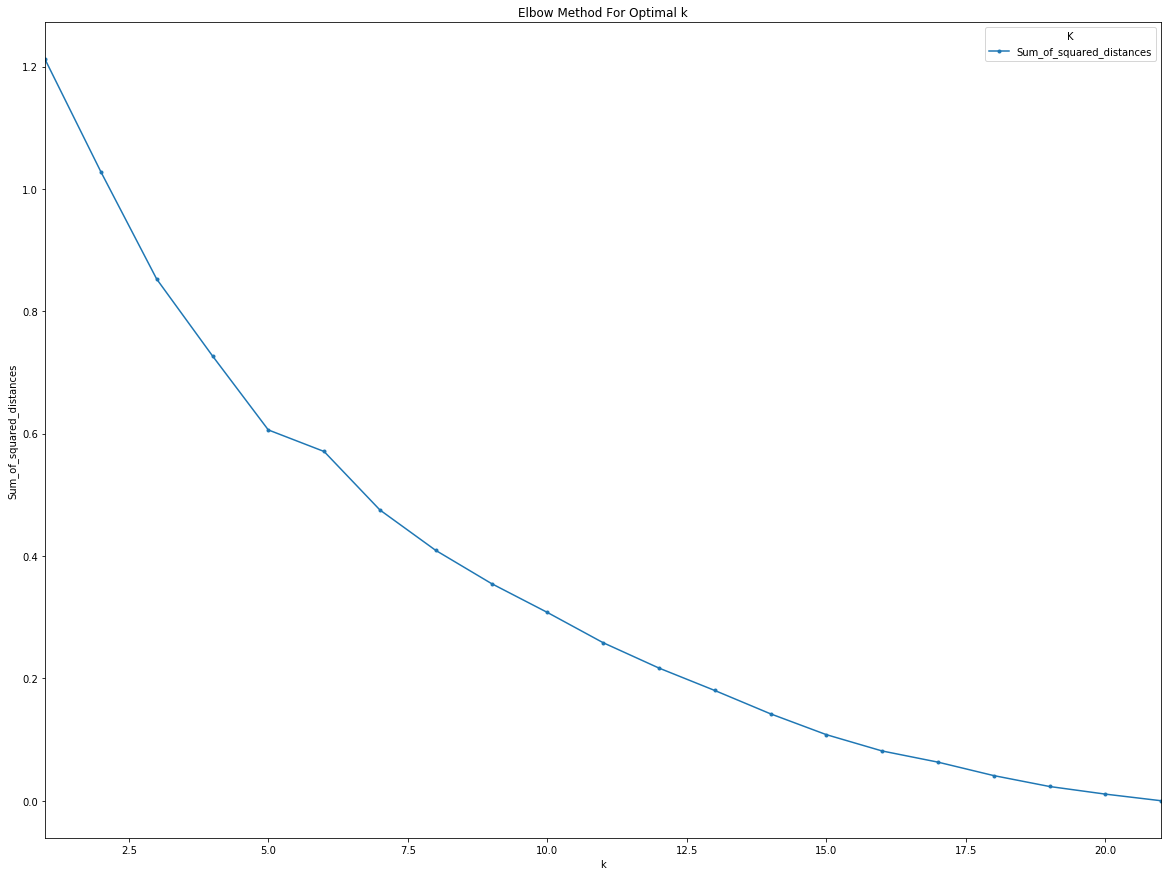

In [32]:
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that our best suitable K value is 5

### Neighborhoods' clusters

In [33]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 0, 3, 3, 3, 3, 3, 3, 4])

### Now let's put our cluster labels in our districts_venues_sorted Dataframe
First, let's remove the rows in our original dataframe for which the Foursquare call didn't return any venues

In [34]:
df['District'] = districts_venues_sorted['District']
print(df.shape)
df.isnull().sum()
df.dropna(how = 'any', axis = 0, inplace = True)
print(df.shape)
print(districts_venues_sorted.shape)

(39, 24)
(21, 24)
(21, 11)


# Segment the districts by population nationality and most common venues
### Then, let's create a new dataframe that contains the cluster labels as well as the Top 10 venues per district

In [35]:
madrid_merged = df

# add clustering labels
madrid_merged['Cluster Labels'] = kmeans.labels_

# merge Madrid_grouped with Madrid_data to add latitude/longitude for each district
madrid_merged = madrid_merged.join(districts_venues_sorted.set_index('District'), on='District')
madrid_merged[['Latitude', 'Longitude']] = coordinates_df[['Latitude', 'Longitude']]
madrid_merged['Latitude'] = madrid_merged['Latitude'].astype(float)
madrid_merged['Longitude'] = madrid_merged['Longitude'].astype(float)
print(madrid_merged.shape)
madrid_merged.head() # check the last columns!

(21, 37)


,Country of Origin,Total Ciudad de Madrid,Centro,Arganzuela,Retiro,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Rumanía,45036.0,815.0,754.0,480.0,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0,Arganzuela,3,Restaurant,Spanish Restaurant,Bakery,Grocery Store,Tapas Restaurant,Gym / Fitness Center,Falafel Restaurant,Burger Joint,Hotel,Plaza,40.415347,-3.707371
1,China,37276.0,1508.0,1356.0,564.0,755.0,652.0,1988.0,816.0,1733.0,960.0,2554.0,4398.0,9207.0,3602.0,564.0,1960.0,1104.0,1236.0,685.0,472.0,972.0,190.0,Barajas,3,Hotel,Restaurant,Spanish Restaurant,Coffee Shop,Tapas Restaurant,Supermarket,Mexican Restaurant,Brewery,Breakfast Spot,Plaza,40.402733,-3.695403
2,Ecuador,23953.0,647.0,741.0,265.0,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0,Carabanchel,0,Metro Station,Soccer Field,Burger Joint,Mobile Phone Shop,Pizza Place,Plaza,Nightclub,Bakery,Fast Food Restaurant,Tapas Restaurant,40.408072,-3.676729
3,Venezuela,23359.0,1563.0,913.0,638.0,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0,Centro,3,Plaza,Tapas Restaurant,Spanish Restaurant,Hostel,Coffee Shop,Bistro,Ice Cream Shop,Café,Cocktail Bar,Mexican Restaurant,40.430000,-3.677778
4,Colombia,22618.0,998.0,717.0,483.0,803.0,551.0,822.0,659.0,999.0,454.0,1786.0,3395.0,1752.0,1733.0,482.0,1792.0,910.0,1618.0,740.0,384.0,1282.0,258.0,Chamartin,3,Spanish Restaurant,Restaurant,Grocery Store,Tapas Restaurant,Bakery,Coffee Shop,Japanese Restaurant,Gastropub,Park,Pizza Place,40.453333,-3.677500


### Cluster visualization

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['District'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###  Let's examine our clusters

#### Cluster One

In [37]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Origin'], ascending = False)

,Country of Origin,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
12,Filipinas,578.0,661.0,4473.0,771.0,442.0,568.0,629.0,400.0,225.0,418.0,76.0,590.0,300.0,140.0,25.0,24.0,152.0,30.0,Puente de Vallecas,0,Fast Food Restaurant,Café,Gym,Grocery Store,Hotel,Supermarket,Camera Store,Tapas Restaurant,South American Restaurant,Coffee Shop,40.398204,-3.669059
2,Ecuador,619.0,380.0,1395.0,453.0,632.0,387.0,2194.0,3674.0,1806.0,3290.0,491.0,2471.0,401.0,2017.0,498.0,439.0,1015.0,138.0,Carabanchel,0,Metro Station,Soccer Field,Burger Joint,Mobile Phone Shop,Pizza Place,Plaza,Nightclub,Bakery,Fast Food Restaurant,Tapas Restaurant,40.408072,-3.676729
11,Bolivia,342.0,315.0,576.0,280.0,401.0,225.0,1458.0,2625.0,2827.0,1573.0,227.0,1086.0,479.0,737.0,222.0,159.0,454.0,71.0,Moratalaz,0,Park,Pizza Place,Brewery,Café,Soccer Field,Bar,Bakery,Plaza,Nightclub,Ice Cream Shop,40.381336,-3.706856


#### Cluster Two

In [38]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Origin'], ascending = False)

,Country of Origin,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
19,Reino Unido,550.0,466.0,329.0,501.0,313.0,304.0,211.0,170.0,81.0,142.0,59.0,285.0,319.0,61.0,49.0,27.0,120.0,74.0,Villa de Vallecas,1,Soccer Field,Grocery Store,Spanish Restaurant,Food,Breakfast Spot,Train Station,Dog Run,Fast Food Restaurant,Food Stand,Food & Drink Shop,40.426001,-3.612764


#### Cluster Three

In [39]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Origin'], ascending = False)

,Country of Origin,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
20,Bangladesh,32.0,21.0,210.0,48.0,27.0,14.0,257.0,410.0,175.0,649.0,23.0,179.0,27.0,489.0,57.0,32.0,78.0,2.0,Villaverde,2,Pizza Place,Plaza,Diner,Spanish Restaurant,Women's Store,Falafel Restaurant,Food & Drink Shop,Food,Flea Market,Fish Market,40.470196,-3.58489


#### Cluster Four

In [40]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Origin'], ascending = False)

,Country of Origin,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
3,Venezuela,1564.0,933.0,1310.0,794.0,1428.0,630.0,1448.0,1870.0,875.0,1829.0,480.0,1858.0,1434.0,909.0,762.0,321.0,1486.0,314.0,Centro,3,Plaza,Tapas Restaurant,Spanish Restaurant,Hostel,Coffee Shop,Bistro,Ice Cream Shop,Café,Cocktail Bar,Mexican Restaurant,40.430000,-3.677778
0,Rumanía,753.0,680.0,1468.0,597.0,1830.0,991.0,4904.0,5873.0,2241.0,4784.0,1286.0,2888.0,1466.0,3646.0,3384.0,2606.0,2929.0,661.0,Arganzuela,3,Restaurant,Spanish Restaurant,Bakery,Grocery Store,Tapas Restaurant,Gym / Fitness Center,Falafel Restaurant,Burger Joint,Hotel,Plaza,40.415347,-3.707371
13,Portugal,695.0,534.0,590.0,509.0,693.0,365.0,533.0,658.0,283.0,597.0,173.0,612.0,727.0,302.0,262.0,168.0,565.0,191.0,Retiro,3,Spanish Restaurant,Tapas Restaurant,Supermarket,Museum,Grocery Store,Gym,Mediterranean Restaurant,Food & Drink Shop,Pizza Place,Burger Joint,40.409869,-3.644436
7,Perú,612.0,419.0,965.0,567.0,805.0,368.0,2026.0,2425.0,1131.0,2079.0,668.0,1726.0,603.0,1280.0,564.0,338.0,810.0,106.0,Fuencarral-El Pardo,3,Clothing Store,Fast Food Restaurant,Burger Joint,Italian Restaurant,Tapas Restaurant,Sporting Goods Shop,Pizza Place,Restaurant,Chocolate Shop,Kebab Restaurant,40.478611,-3.709722
8,Paraguay,521.0,657.0,3311.0,584.0,1024.0,636.0,2061.0,2152.0,727.0,1354.0,360.0,1619.0,583.0,870.0,217.0,199.0,581.0,151.0,Hortaleza,3,Breakfast Spot,Supermarket,Pizza Place,Plaza,Bar,Food,Restaurant,Chinese Restaurant,Spanish Restaurant,Pub,40.435151,-3.718765
5,Marruecos,322.0,280.0,1393.0,320.0,930.0,342.0,1539.0,2223.0,942.0,3437.0,258.0,1011.0,426.0,3372.0,1655.0,802.0,649.0,333.0,Chamberí,3,Spanish Restaurant,Restaurant,Bar,Café,Brewery,Japanese Restaurant,Tapas Restaurant,Mexican Restaurant,Plaza,Italian Restaurant,40.460556,-3.700000
6,Italia,1817.0,1060.0,1194.0,1640.0,1195.0,710.0,826.0,915.0,412.0,704.0,310.0,1258.0,1109.0,330.0,427.0,189.0,786.0,337.0,Ciudad Lineal,3,Spanish Restaurant,Gastropub,Supermarket,Restaurant,Burger Joint,Argentinian Restaurant,Pizza Place,Cocktail Bar,Café,Gym / Fitness Center,40.432792,-3.697186
10,Honduras,332.0,337.0,755.0,317.0,863.0,335.0,2021.0,2870.0,1115.0,2483.0,281.0,1062.0,349.0,1040.0,387.0,165.0,598.0,62.0,Moncloa-Aravaca,3,Restaurant,Spanish Restaurant,Bar,Pizza Place,Tapas Restaurant,Mediterranean Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Pub,40.383669,-3.727989
14,Francia,968.0,554.0,387.0,699.0,366.0,347.0,196.0,188.0,66.0,138.0,85.0,599.0,1802.0,68.0,59.0,52.0,357.0,197.0,Salamanca,3,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Seafood Restaurant,Coffee Shop,Burger Joint,Supermarket,Tapas Restaurant,Clothing Store,Mexican Restaurant,40.450000,-3.650000
18,Estados Unidos de América,749.0,389.0,300.0,657.0,297.0,428.0,207.0,125.0,86.0,139.0,232.0,252.0,206.0,54.0,51.0,33.0,101.0,57.0,Vicálvaro,3,Pizza Place,Spanish Restaurant,Beer Bar,Breakfast Spot,Café,Camera Store,Restaurant,Fast Food Restaurant,Tapas Restaurant,Sandwich Place,40.404200,-3.608060


#### Cluster Five

In [41]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[0] + list(range(5, madrid_merged.shape[1]))]].sort_values(by = ['Country of Origin'], ascending = False)

,Country of Origin,Salamanca,Chamartin,Tetuán,Chamberí,Fuencarral-El Pardo,Moncloa-Aravaca,Latina,Carabanchel,Usera,Puente de Vallecas,Moratalaz,Ciudad Lineal,Hortaleza,Villaverde,Villa de Vallecas,Vicálvaro,San Blas-Canillejas,Barajas,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
15,Ucrania,220.0,176.0,221.0,149.0,312.0,168.0,1745.0,1251.0,428.0,912.0,239.0,348.0,282.0,1649.0,256.0,152.0,390.0,56.0,San Blas-Canillejas,4,Metro Station,Asian Restaurant,Snack Place,Gas Station,Supermarket,Grocery Store,Shopping Mall,Gym,Dog Run,Diner,40.469457,-3.640482
9,República Dominicana,344.0,322.0,2272.0,443.0,589.0,536.0,1501.0,1607.0,1202.0,1989.0,223.0,1581.0,359.0,1881.0,296.0,151.0,889.0,103.0,Latina,4,Metro Station,Pizza Place,Grocery Store,Falafel Restaurant,Fast Food Restaurant,Shopping Mall,Bakery,Park,Train Station,Greek Restaurant,40.402461,-3.741294


## Conclusions:

According to data obtained from The Madrid City Hall's Web Portal, there is a considerable Colombian population registered in town which ranks five with 22.618 K as per survey. Furthermore, it can be seen the Colombian citizens are mostly located in the districts Caranbachel (3395 inhabitants), Ciudad Lineal (1792 inhabitants), Latina (1786 inhabitants), Usera (1752 inhabitants) and Puente de Vallecas (1733 inhabitants).

Regarding the districs outlined above, Carabanchel which belong to Cluster 1 is the one with the highest Colombian population and is also considered one of the most diverse neighborhoods in the country, with a large population of immigrants. Futhermore, if we carry out a deeper look of it about its most popular venues, it can be observed there isn't any Colombian and/or Latino restaurants; there are just Tapas and Fast-Food Restaurant. As a consequence, it could be a good opportunity to open a Colombian restaurant and in the mid-term some other Latino restaurants due to the huge potential of the district.

Regarding the other districts with a considerable Colombian citizens population like Ciudad Lineal, Latina, Usera and Puente de Vallecas located in the clusters 1, 4, 5 its population are mostly Latinos, mixed with some other Europeans and Asians. Besides, having analyzed their most popular venues, there are several Fast Food, Argentinian, and South American restaurants.
So, in these clusters, it can be seen the existing restaurants matches the population's nationalities and food preferences.

If someone might be interested to open a new Colombian restaurant in the city or any kind of Latino restaurant, it would only be necessary to find a place where there are similar restaurants like the one considered to be opened, make a market research, and find similar clusters of population in the city that don't have them yet or have very few venues like the one to be created.

In conlussion, taking into consideration the explanations given above as well as the data, it is highly possible that the clusters 1, 4 and 5 could be a good place to open a Colombian restaurant. As explained above, the same logic could apply to open other type of restaurants or businesses in any other area of the city. It is just necessary to examine the existing businesses in the target area and study the population, then compare these 2 factors with the same ones in areas where there are existing businesses like the one to be opened, and finally verify if the matching is correct.